### [ogbn-arxiv](https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv)

In [1]:
from ogb.nodeproppred import PygNodePropPredDataset
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import degree, to_undirected
from transformers import BertTokenizer
import pickle


dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='../data') 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
data = dataset[0] # pyg graph object



In [2]:
len(dataset)

1

The dataset contains a single graph (transductive).

In [3]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node vectorized text size (provided by OGB): {data.num_node_features}")

print(f"Training size: {len(train_idx)}")
print(f"Validation size: {len(valid_idx)}")
print(f"Test size: {len(test_idx)}")


Number of nodes: 169343
Number of edges: 1166243
Node vectorized text size (provided by OGB): 128
Training size: 90941
Validation size: 29799
Test size: 48603


### Class distribution

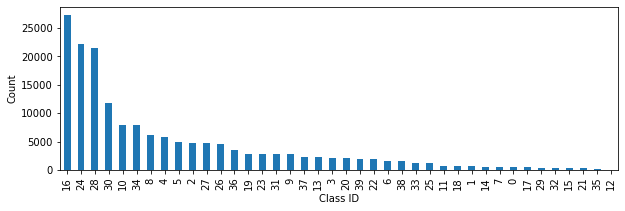

In [7]:
plot_dir = '../visualization/EDA'
pd.Series(data.y.flatten()).value_counts().plot.bar(figsize=(10, 3))
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.savefig(f"{plot_dir}/ClassDistribution.pdf", bbox_inches='tight')

Quite imbalanced

Most 2 popular classes:
- `16` - arxiv cs cv - Computer Vision and Pattern Recognition
- `24` - arxiv cs lg - Machine Learning

Most 2 unpopular classes:
- `35` - arxiv cs os - Operating Systems
- `12` - arxiv cs gl - General Literature 

### Node degrees

Consider the undirected version of the graph, similarily to GIANT

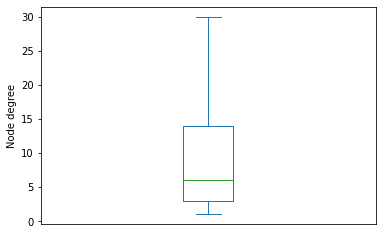

In [25]:
node_degrees = degree(to_undirected(data.edge_index)[0])
pd.Series(node_degrees).plot.box(showfliers=False)
pd.Series(node_degrees).describe(percentiles=[.01, .25, .5, .75, .99])
plt.ylabel("Node degree")
plt.xticks([])
plt.savefig(f"{plot_dir}/NodeDegree.pdf", bbox_inches='tight')

Ommiting the outliers for visibility

Most of the node degrees are low: 95% are below 40.

GIANT filters out the nodes that had degree > 1000. The portion of filtered out nodes:

In [26]:
(pd.Series(node_degrees) > 1000).value_counts(normalize=True)[True]

0.0003365949581618372

Small portion --> reasonable choice

### Node sequential text 

In [28]:
raw_text_path = '../data/proc_data_multi_task/ogbn-arxiv/X.all.txt'
with open(raw_text_path, "r") as fin:
    node_text_list = fin.readlines()
node_text_list[0]

"evasion attacks against machine learning at test time In security-sensitive applications, the success of machine learning depends on a thorough vetting of their resistance to adversarial data. In one pertinent, well-motivated attack scenario, an adversary may attempt to evade a deployed system at test time by carefully manipulating attack samples. In this work, we present a simple but effective gradient-based approach that can be exploited to systematically assess the security of several, widely-used classification algorithms against evasion attacks. Following a recently proposed framework for security evaluation, we simulate attack scenarios that exhibit different risk levels for the classifier by increasing the attacker's knowledge of the system and her ability to manipulate attack samples. This gives the classifier designer a better picture of the classifier performance under evasion attacks, and allows him to perform a more informed model selection (or parameter setting). We evalu

In [29]:
text_tokenizer_path = '../data/proc_data_multi_task/ogbn-arxiv/xrt_models/text_encoder/text_tokenizer'
tokenizer = BertTokenizer.from_pretrained(text_tokenizer_path)

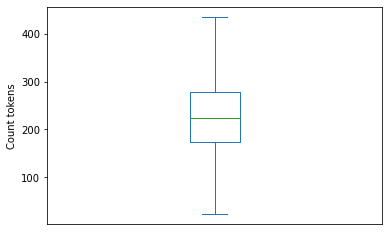

In [31]:
# count_tokens = [tokenizer(text, padding=False, truncation=False, return_length=True)['length'] 
#                 for text in node_text_list]
# with open('count_tokens.pickle', 'wb') as handle:
#     pickle.dump(count_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('count_tokens.pickle', 'rb') as handle:
    count_tokens = pickle.load(handle)
    
pd.Series(count_tokens).plot.box(showfliers=False)
pd.Series(count_tokens).describe(percentiles=[.1, .25, .5, .75, .9])
plt.ylabel("Count tokens")
plt.xticks([])
plt.savefig(f"{plot_dir}/CountTokens.pdf", bbox_inches='tight')


The GIANT preprocessing truncate the text, where `max_length=128`. The portion of text we are keeping for each node is:

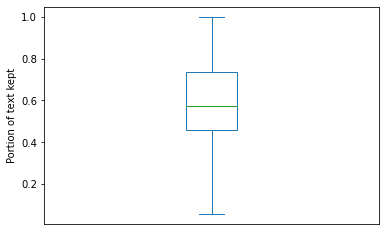

In [32]:
keep = [128/x if x > 128 else 1 for x in count_tokens]
pd.Series(keep).plot.box(showfliers=False)
pd.Series(keep).describe(percentiles=[.1, .25, .5, .75, .9])
plt.ylabel("Portion of text kept")
plt.xticks([])
plt.savefig(f"{plot_dir}/PortionOfTextKept.pdf", bbox_inches='tight')

Word cloud

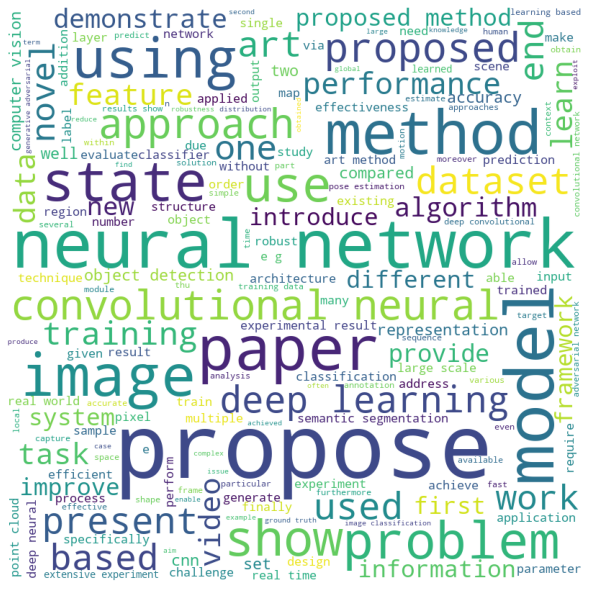

In [42]:
from wordcloud import WordCloud, STOPWORDS


topic = 16
topic_text_list = [node_text_list[i] for i in range(0, len(node_text_list)) if data.y.flatten()[i]==topic]

topic_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for text in topic_text_list:
    tokens = text.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    topic_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(topic_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig(f"{plot_dir}/WordCloudTopic{topic}.pdf", bbox_inches='tight')


### Percentages of edges within class and between class

In [43]:
edge_index = to_undirected(data.edge_index)
count_within_class = 0
count_between_class = 0
for edge_id in range(0, edge_index.shape[1]):
    node0 = edge_index[0][edge_id]
    node1 = edge_index[1][edge_id]
    if data.y[node0] == data.y[node1]:
        count_within_class += 1
    else:
        count_between_class += 1
        
print(f'{count_within_class/edge_index.shape[1] * 100}% of the edges are within class')
print(f'{count_between_class/edge_index.shape[1] * 100}% of the edges are between class')

65.42197738985782% of the edges are within class
34.57802261014217% of the edges are between class
